<div style="border-radius:10px; padding: 15px; background-color: #e3e6fa; text-align:left; font-size:120%; background-image: url(https://i.postimg.cc/T1gYxL48/v870-tang-35.jpg)">

<h4 align="left"><span style="font-weight:700; font-size:160%"><font color=#005f26> Face Recognition Dataset:</font></span></h4>.

<a id="import"></a>
<h2><b><span style="color:#005f26">🔶 Step 1 | </span><span style="color:#ff6200">Import Libraries</span></b></h2>

In [1]:
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 2 | </span><span style="color:#ff6200">Reading Data</span></b></h2>

In [3]:
dataset_path = '/kaggle/input/face-recognition-dataset/Faces/Faces'
output_path = '/kaggle/working/organized_faces'

if not os.path.exists(output_path):
    os.makedirs(output_path)

for image_name in os.listdir(dataset_path):
    image_path = os.path.join(dataset_path, image_name)

    if os.path.isfile(image_path):
        class_name = image_name.split('_')[0]
        class_dir = os.path.join(output_path, class_name)

        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        dest_path = os.path.join(class_dir, image_name)

        with open(image_path, 'rb') as src_file, open(dest_path, 'wb') as dst_file:
            shutil.copyfileobj(src_file, dst_file)

<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ At first,how many image in each class 
    </p>
</div>

Total number of classes: 31
Class "Amitabh Bachchan": 74 images
Class "Lisa Kudrow": 70 images
Class "Akshay Kumar": 50 images
Class "Jessica Alba": 108 images
Class "Charlize Theron": 78 images
Class "Ellen Degeneres": 75 images
Class "Dwayne Johnson": 61 images
Class "Marmik": 32 images
Class "Virat Kohli": 49 images
Class "Henry Cavill": 106 images
Class "Vijay Deverakonda": 115 images
Class "Hugh Jackman": 112 images
Class "Margot Robbie": 72 images
Class "Brad Pitt": 120 images
Class "Alexandra Daddario": 92 images
Class "Kashyap": 30 images
Class "Roger Federer": 77 images
Class "Billie Eilish": 98 images
Class "Natalie Portman": 105 images
Class "Hrithik Roshan": 101 images
Class "Camila Cabello": 87 images
Class "Priyanka Chopra": 102 images
Class "Anushka Sharma": 68 images
Class "Andy Samberg": 92 images
Class "Robert Downey Jr": 113 images
Class "Claire Holt": 96 images
Class "Zac Efron": 91 images
Class "Alia Bhatt": 79 images
Class "Courtney Cox": 80 images
Class "Tom Crui

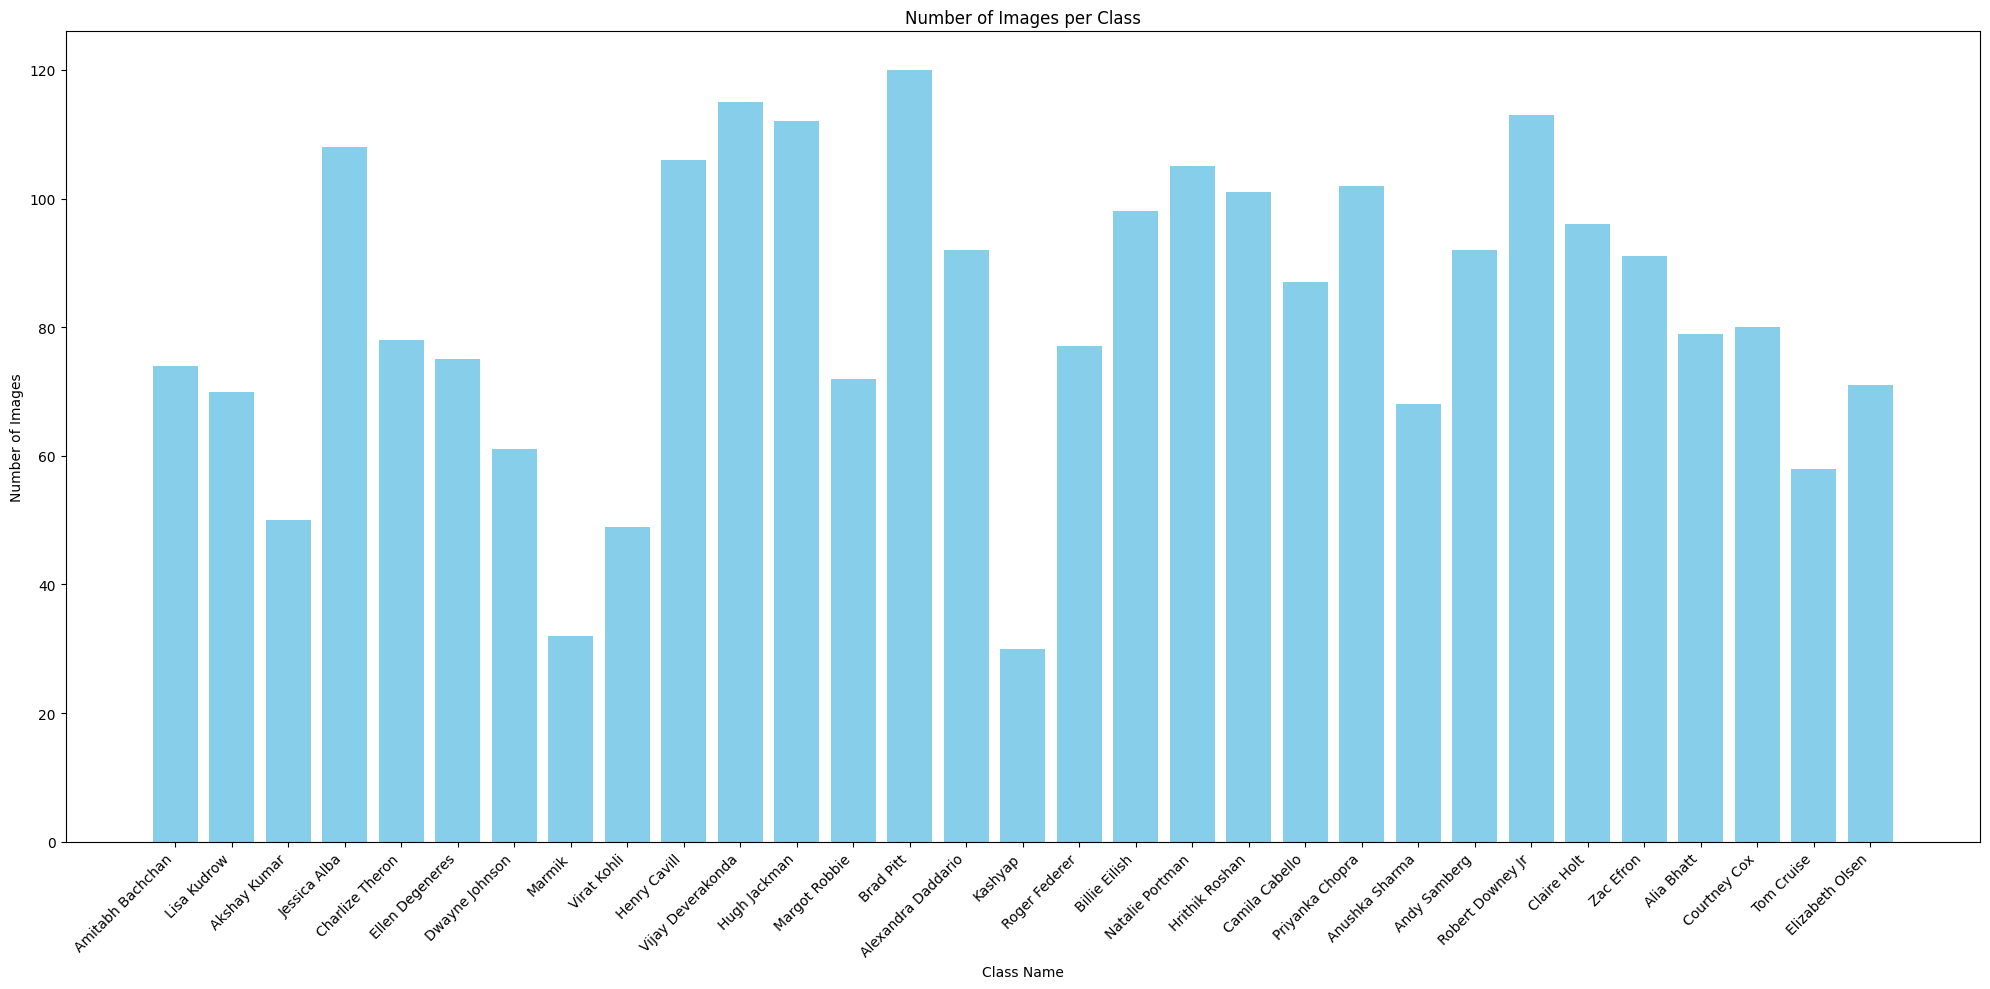

In [4]:
import os
import matplotlib.pyplot as plt


dataset_path = '/kaggle/working/organized_faces'


class_image_count = {}


for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    
    
    if os.path.isdir(class_dir):
        
        num_images = len([img for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))])
        class_image_count[class_name] = num_images

num_classes = len(class_image_count)


print(f'Total number of classes: {num_classes}')

for class_name, num_images in class_image_count.items():
    print(f'Class "{class_name}": {num_images} images')


plt.figure(figsize=(20, 10))
plt.bar(class_image_count.keys(), class_image_count.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')  
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.tight_layout()  
plt.show()

<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ <code>opservation</code>-> there are impalance in classes .
    </p>
</div>

In [16]:
dataset_path = '/kaggle/working/organized_faces'

base_dir = '/kaggle/working/split_dataset'
train_dir = os.path.join(base_dir, 'train_dir')
test_dir = os.path.join(base_dir, 'test_dir')

for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)


def copy_images(image_paths, dest_folder):
    for img_path in image_paths:
        class_name = os.path.basename(os.path.dirname(img_path))
        class_folder = os.path.join(dest_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        shutil.copy(img_path, class_folder)


def get_images_from_class(class_name):
    class_dir = os.path.join(dataset_path, class_name)
    images = []
    if os.path.isdir(class_dir):
        for entry in os.scandir(class_dir):
            if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
                images.append((entry.path, class_name))
    return images


all_images = []
all_labels = []

# Loop through all classes and collect images and labels
for class_name in os.listdir(dataset_path):
    images_in_class = get_images_from_class(class_name)
    all_images.extend([img_path for img_path, _ in images_in_class])
    all_labels.extend([label for _, label in images_in_class])


# Split data into  train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Copy images to respective directories
copy_images(train_images, train_dir)
copy_images(test_images, test_dir)


<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 2 | </span><span style="color:#ff6200">Show some image</span></b></h2>

Displaying some images from train_images...


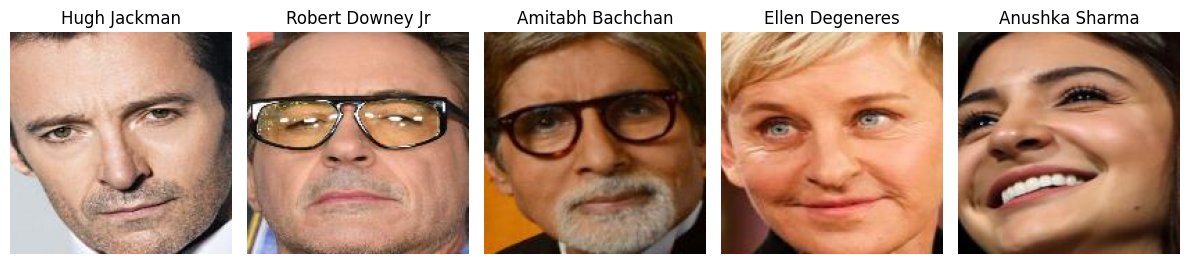

In [6]:
from PIL import Image  # Import the Image module from Pillow
import matplotlib.pyplot as plt

# Function to display some images
def display_images(image_paths, labels, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        img = Image.open(image_paths[i])  # Open the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])  # Set the label as the title
    plt.tight_layout()
    plt.show()

# Display a few images from the virtual document set
print("Displaying some images from train_images...")
display_images(train_images, train_labels, num_images=5)


<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 4 | </span><span style="color:#ff6200">Data Augmentation</span></b></h2>

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

train_dir = '/kaggle/working/split_dataset/train_dir'
test_dir = '/kaggle/working/split_dataset/test_dir'

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,          
    width_shift_range=0.2,      
    height_shift_range=0.2,      
    shear_range=0.2,             
    zoom_range=0.2,              
    horizontal_flip=True,       
    fill_mode='nearest'          
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(224, 224), 
    batch_size=32, 
    class_mode='categorical', 
    shuffle=False
)

Found 2049 images belonging to 31 classes.
Found 513 images belonging to 31 classes.


<div style="background-color: #f2faf5">
    <p style="color:navy; font-size:120%">
       ➡️ <code></code>-> compute_class_weight.
    </p>
</div>

In [8]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.6524193548387096, 1: 0.8931996512641673, 2: 1.0491551459293396, 3: 1.120284308365227, 4: 0.8931996512641673, 5: 1.2240143369175627, 6: 0.847394540942928, 7: 0.688508064516129, 8: 0.9442396313364055, 9: 1.0660770031217481, 10: 0.8583996648512777, 11: 1.0327620967741935, 12: 1.348913759052008, 13: 1.1595925297113752, 14: 1.1016129032258064, 15: 0.7776091081593928, 16: 0.8160095579450418, 17: 0.7426603841971728, 18: 0.7685671417854464, 19: 2.754032258064516, 20: 1.180299539170507, 21: 1.139599555061179, 22: 2.542183622828784, 23: 0.7868663594470046, 24: 0.8160095579450418, 25: 0.7344086021505376, 26: 1.0660770031217481, 27: 1.4368863955119215, 28: 0.7184431977559608, 29: 1.694789081885856, 30: 0.9054352629253204}


<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 4 | </span><span style="color:#ff6200"> Model</span></b></h2>

<div style="border-radius:10px; padding: 15px; background-color: #e3e6fa; text-align:left; font-size:120%; background-image: url(https://i.postimg.cc/T1gYxL48/v870-tang-35.jpg)">

<h4 align="left"><span style="font-weight:700; font-size:160%"><font color=#005f26> Xception</font></span></h4>.

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734010890.273867     117 service.cc:145] XLA service 0x7b9928003100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734010890.273933     117 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/65 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.0391 - loss: 3.8924  

I0000 00:00:1734010896.989831     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step - accuracy: 0.0489 - loss: 3.6776 - val_accuracy: 0.0429 - val_loss: 3.3476
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.0937 - loss: 3.2532 - val_accuracy: 0.0819 - val_loss: 3.2157
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.1725 - loss: 2.9520 - val_accuracy: 0.1559 - val_loss: 3.0055
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.1862 - loss: 2.8354 - val_accuracy: 0.2398 - val_loss: 2.8034
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 326ms/step - accuracy: 0.2388 - loss: 2.6291 - val_accuracy: 0.2924 - val_loss: 2.5822
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 326ms/step - accuracy: 0.2866 - loss: 2.4979 - val_accuracy: 0.3353 - val_loss: 2.4206
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 327ms/step - accuracy: 0.2956 - loss: 2.4341 - val_accuracy: 0.3548 - val_loss: 2.2868
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 320ms/step - accuracy: 0.3286 - loss: 2.2818 - val_accuracy

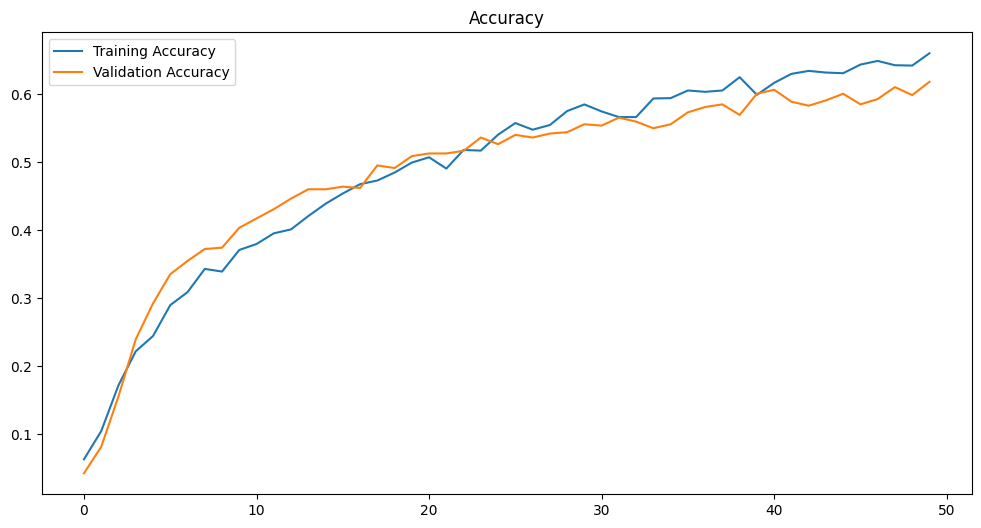

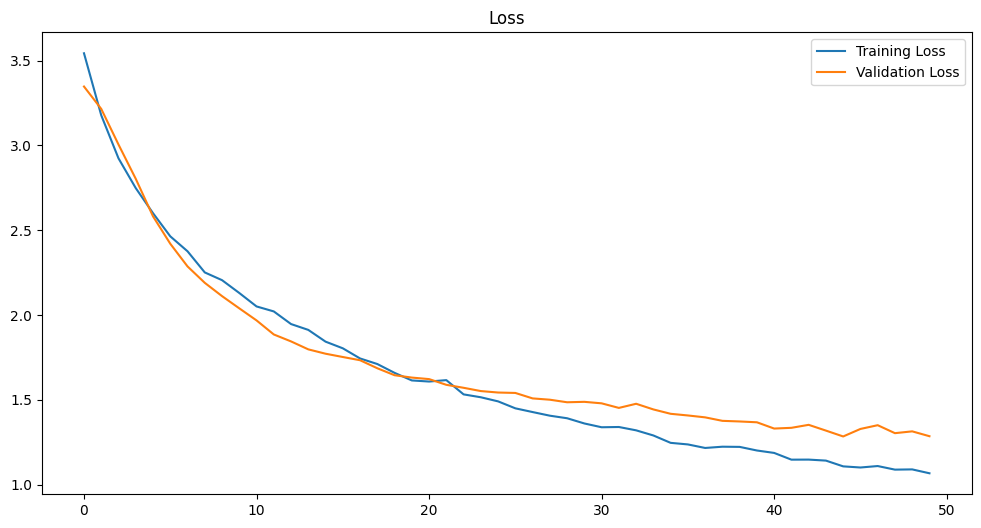

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Load the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False
# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),

    
    # Output layer
    Dense(train_generator.num_classes, activation='softmax')  # Number of classes
])
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('xception_best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    class_weight=class_weights_dict,
    validation_data=test_generator,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 5 | </span><span style="color:#ff6200">Save</span></b></h2>

In [17]:
from tensorflow.keras.models import load_model
model_path = "/kaggle/working/Xception_last.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

# Load the saved model (to ensure it works properly)
loaded_model = load_model(model_path)
print("Model successfully loaded.")

Model saved to /kaggle/working/Xception_last.h5
Model successfully loaded.


<a id="load_data"></a>
<h2><b><span style="color:#005f26">🔶 Step 6 | </span><span style="color:#ff6200">Evaluation </span></b></h2>

<h2><b><span style="color:#005f26"> confusion_matrix|classification_report </span><span style="color:#ff6200"> </span></b></h2>

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step


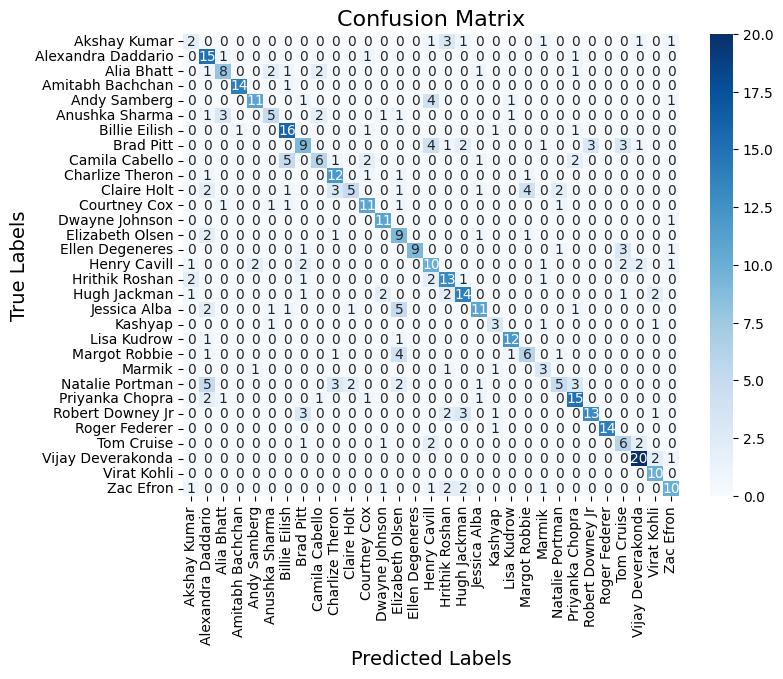

Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.29      0.20      0.24        10
Alexandra Daddario       0.45      0.83      0.59        18
        Alia Bhatt       0.57      0.50      0.53        16
  Amitabh Bachchan       0.93      0.93      0.93        15
      Andy Samberg       0.79      0.61      0.69        18
    Anushka Sharma       0.50      0.36      0.42        14
     Billie Eilish       0.62      0.80      0.70        20
         Brad Pitt       0.47      0.38      0.42        24
    Camila Cabello       0.55      0.35      0.43        17
   Charlize Theron       0.57      0.75      0.65        16
       Claire Holt       0.62      0.26      0.37        19
      Courtney Cox       0.65      0.69      0.67        16
    Dwayne Johnson       0.69      0.92      0.79        12
   Elizabeth Olsen       0.36      0.64      0.46        14
   Ellen Degeneres       1.00      0.60      0.75        15
      Henry Cavi

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict classes for the validation set
y_pred_classes = model.predict(test_generator)  # Get predictions
y_pred_classes = np.argmax(y_pred_classes, axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = test_generator.classes  # True class labels from the validation generator
class_labels = list(test_generator.class_indices.keys())  # Class names

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(report)


<h2><b><span style="color:#005f26">ROC </span><span style="color:#ff6200"> </span></b></h2>

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


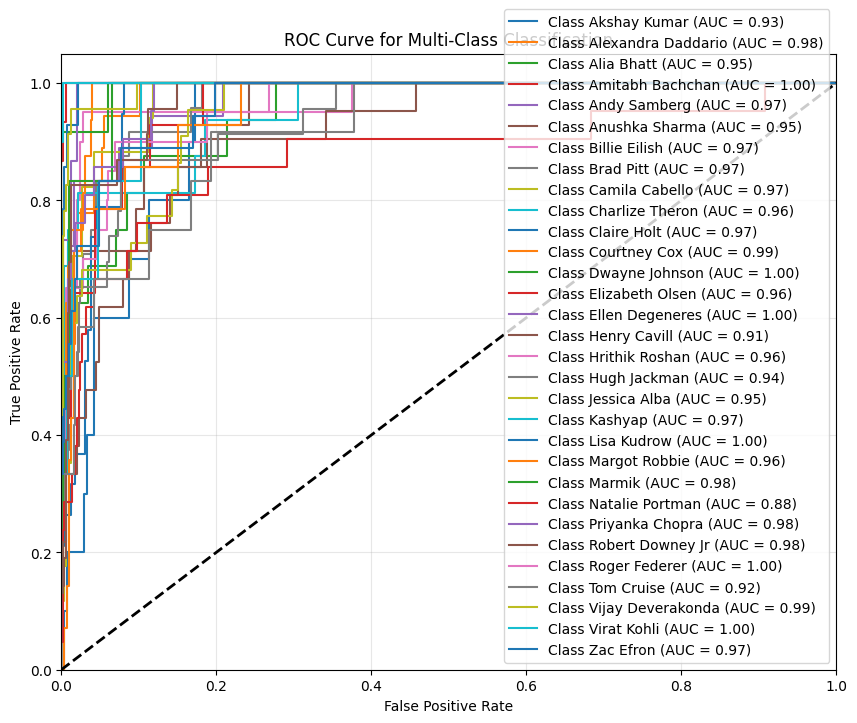

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
# Get the ground truth labels and predicted probabilities
y_true = test_generator.classes  # Ground truth labels
y_prob = model.predict(test_generator)  # Predicted probabilities for each class

# Get class names and number of classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# Binarize the true labels for multi-class ROC
y_true_onehot = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot a diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal for no-skill classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()